# Creation df

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
)
from sklearn.metrics import root_mean_squared_error
import os
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from itertools import combinations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
import time


In [2]:
df = pd.read_csv("simulation_results_with_pressure_without_early_values.csv")

In [3]:
def plot_predictions_vs_actual(
    y_true, y_pred, save_path="graphes_NN", sample_fraction=0.1
):
    """
    Plots predicted values versus actual values and saves the plot as a PDF.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.
        save_path (str): Directory where the PDF file will be saved.
        sample_fraction (float): Fraction of the data to sample for faster plotting.
    """
    # Ensure the directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Reducing the dataset size if it's too large
    if len(y_true) > 1000:  # Only sample if the dataset is large
        sample_size = int(len(y_true) * sample_fraction)
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true = y_true[indices]
        y_pred = y_pred[indices]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_true, y_pred, alpha=0.7, label="Predicted vs Actual")
    ax.plot(
        [min(y_true), max(y_true)], [min(y_true), max(y_true)], "r--", label="Ideal"
    )
    ax.set_title("Predicted vs Actual Values")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(True)

    # Save the plot as a PDF
    pdf_path = os.path.join(save_path, "predicted_vs_actual.pdf")
    fig.savefig(pdf_path, format="pdf")
    plt.close(fig)  # Close the figure to free memory

    print(f"Graph saved to {pdf_path}")

# Linear Regression

In [45]:
def linear_regression_model(df, feature_expansion=False, regularization=False, folder=".", alpha=1.0, plot_and_save=False, plot_coefs=False, degree=7):
    # Création du dossier si non existant
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Sélection des variables d'entrée et de sortie
    X = df[["lhgr", "fuel_radius", "gap_size", "clad_thickness", "coolant_temperature", "time"]]
    y = df["volAverage(T)"]
    
    # Standardisation des données pour éviter les problèmes de conditionnement
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Expansion des caractéristiques si activée
    if feature_expansion:
        poly = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)
        X_expanded = poly.fit_transform(X_scaled)
        feature_names = poly.get_feature_names_out(X.columns)
        X_scaled = X_expanded
    
    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Création du modèle avec régularisation (Ridge) si activée
    if regularization:
        model = Ridge(alpha=alpha)
    else:
        model = LinearRegression()
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul de l'erreur MSE et RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    
    # Paramètres utilisés dans le graphique
    feature_expansion_str = "Feature Expansion" if feature_expansion else "No Feature Expansion"
    regularization_str = f"Regularization (alpha={alpha})" if regularization else "No Regularization"

    # Plot et sauvegarde des résultats de prédiction si activé
    if plot_and_save:
        plt.figure(figsize=(8, 8))
        plt.scatter(y_test, y_pred, alpha=0.2, label='Predictions')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
        plt.xlabel('Real temperature (K)', fontsize=18)
        plt.ylabel('Predicted temperature (K)', fontsize=18)
        plt.legend(title=f'RMSE: {rmse:.2f} K')
        plt.grid(True)
        plt.tight_layout()
        
        # Increase the tick label size
        plt.tick_params(axis='both', labelsize=16)  # Adjust '14' as per your preference
        
        plt.savefig(f"{folder}/predictions_vs_true_values_{feature_expansion_str}_{regularization_str}_degree{degree}.pdf")
        plt.show()
        plt.close()

    # Plot et sauvegarde des coefficients si activé
    if plot_coefs:
        coefs = model.coef_
        coef_names = X.columns if not feature_expansion else feature_names
        
        # Sélection des 15 plus grands coefficients en valeur absolue
        abs_coefs = np.abs(coefs)
        top_15_indices = np.argsort(abs_coefs)[-15:]
        
        top_15_coefs = coefs[top_15_indices]
        top_15_coef_names = [coef_names[i] for i in top_15_indices]
        
        plt.figure(figsize=(10, 6))
        plt.barh(top_15_coef_names, top_15_coefs)
        plt.xlabel('Coefficient Value', fontsize=18)
        plt.grid(True)
        plt.tight_layout()
        
        # Increase the tick label size
        plt.tick_params(axis='both', labelsize=16)  # Adjust '14' as per your preference
        
        plt.savefig(f"{folder}/top_15_model_coefficients_{feature_expansion_str}_{regularization_str}_degree{degree}.pdf")
        plt.show()
        plt.close()


    return model, mse, rmse


In [ ]:
def evaluate_rmse_time(df, folder=".", regularization=False, alpha=1.0):
    results = []  # Pour stocker les résultats
    for degree in range(1, 11):  # Degré de 1 à 11
        print(f"Evaluating degree {degree}...")
        start_time = time.time()
        
        # Appel de la fonction de régression avec l'expansion des caractéristiques
        model, mse, rmse = linear_regression_model(
            df, 
            feature_expansion=True, 
            regularization=regularization, 
            folder=folder, 
            alpha=alpha, 
            plot_and_save=False, 
            plot_coefs=False,
            degree=degree
        )
        
        elapsed_time = time.time() - start_time  # Temps de calcul
        print(f"Time for degree {degree}: {elapsed_time:.4f} seconds")
        
        # Enregistrement des résultats dans la liste
        results.append({"Degree": degree, "RMSE": rmse, "Computation Time": elapsed_time})
        
        # Sauvegarde dans un fichier CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(f"{folder}/evaluation_results.csv", index=False)
    
    # Lecture des résultats et tracé des courbes
    results_df = pd.read_csv(f"{folder}/evaluation_results.csv")
    
    plt.figure(figsize=(12, 8))

    # Axe principal pour RMSE
    ax1 = plt.gca()
    ax1.plot(results_df['Degree'], results_df['RMSE'], label="RMSE", marker='o', color='blue')
    ax1.set_xlabel('Degree of Polynomial Expansion', fontsize=18)
    ax1.set_ylabel('RMSE', fontsize=18, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)

    # Formatage des axes x pour n'afficher que des entiers
    ax1.set_xticks(np.arange(1, 10, 1))  # Seules les valeurs entières de 1 à 9
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

    # Application de l'échelle logarithmique sur l'axe des RMSE
    ax1.set_yscale('log')

    # Axe secondaire pour le temps de calcul
    ax2 = ax1.twinx()
    ax2.plot(results_df['Degree'], results_df['Computation Time'], label="Computation Time", marker='o', color='black')
    ax2.set_ylabel('Computation Time (s)', fontsize=18, color='black')
    ax2.tick_params(axis='y', labelcolor='black', labelsize=18)

    # Application de l'échelle logarithmique sur l'axe du temps de calcul
    ax2.set_yscale('log')

    # Formatage des axes y pour les entiers
    ax2.tick_params(axis='y', labelsize=18)

    # Grille pour les entiers seulement
    ax1.grid(True, which='both', axis='x', color='gray', linestyle='-', linewidth=0.5)

    # Titre et légendes
    plt.title('RMSE and Computation Time vs Degree of Polynomial Expansion', fontsize=18)
    ax1.legend(loc='upper left', fontsize=18)
    ax2.legend(loc='upper right', fontsize=18)
    
    plt.tight_layout()
    plt.savefig(f"{folder}/rmse_and_computation_time_vs_degree_log.pdf")
    plt.show()


Mean Squared Error: 1481.1741820995328
Root Mean Squared Error (RMSE): 38.48602580287464


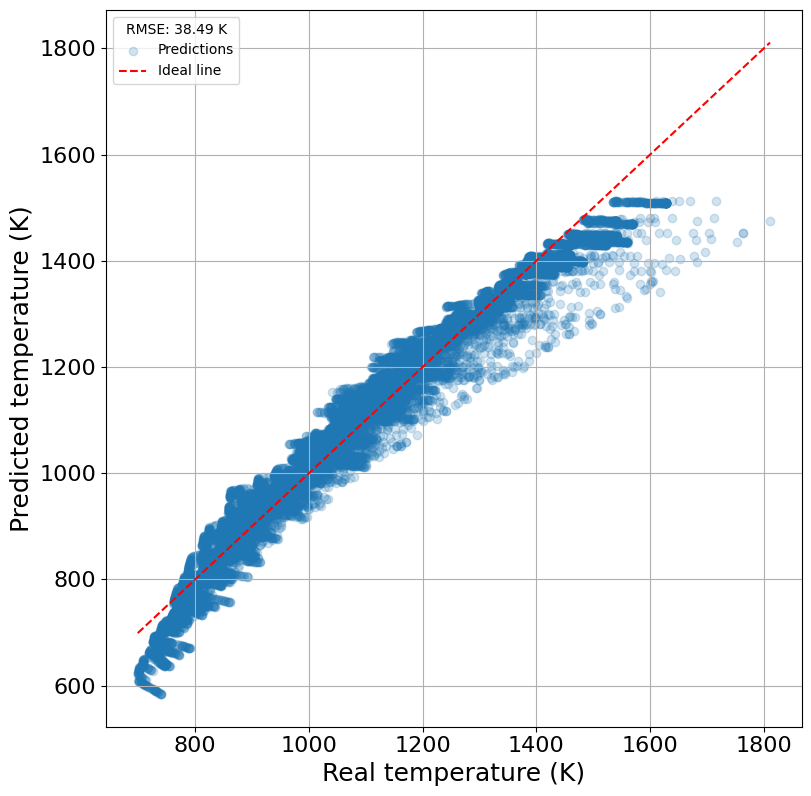

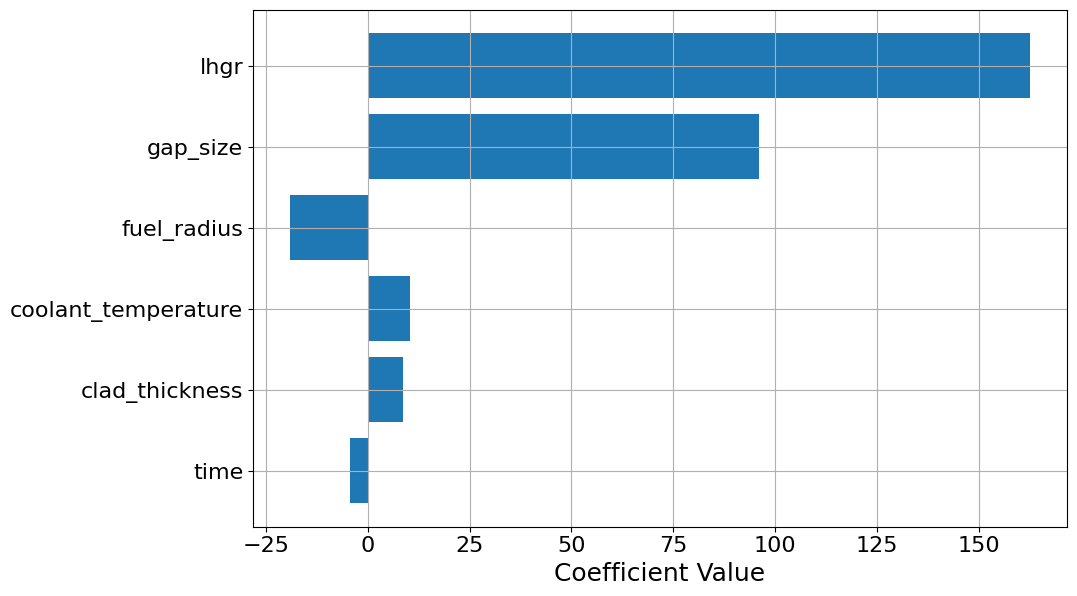

In [48]:
model, mse, rmse = linear_regression_model(df, feature_expansion=False, regularization=True, folder="LR_plots", alpha=1.0, plot_and_save=True, plot_coefs=True, degree=1)

# Fully connected NN

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers):
        super(NeuralNetwork, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
def fully_connected_NN(
    df, K, L, num_epochs, lr_init, lr_step, lr_gamma, save_path="model_save"
):
    # Définir les entrées (features) et la sortie (target)
    X = df[
        [
            "lhgr",
            "fuel_radius",
            "gap_size",
            "clad_thickness",
            "coolant_temperature",
            "time",
        ]
    ].values
    y = df["volAverage(T)"].values

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardiser les données d'entrée
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convertir les données en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Initialisation du modèle
    model = NeuralNetwork(
        input_size=X_train_tensor.shape[1], hidden_size=K, num_hidden_layers=L
    )

    # Définir la fonction de perte, l'optimiseur et le scheduler
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_init)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

    # Entraîner le modèle
    train_losses = []
    test_losses = []
    y_pred_all = []  # Liste pour stocker les prédictions
    y_test_all = []  # Liste pour stocker les valeurs réelles

    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Ajuster le learning rate avec le scheduler
        scheduler.step()

        # Évaluation sur l'ensemble de test
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test_tensor)
            test_loss = criterion(test_predictions, y_test_tensor)

            # Stocker les valeurs réelles et prédites pour le tracé
            y_pred_all.append(test_predictions.numpy().flatten())
            y_test_all.append(y_test_tensor.numpy().flatten())

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}"
        )

    # Convertir les listes en tableaux numpy pour faciliter l'utilisation
    y_pred_all = np.concatenate(y_pred_all)
    y_test_all = np.concatenate(y_test_all)

    # Sauvegarde des informations nécessaires pour utiliser le modèle comme boîte noire
    os.makedirs(save_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
    np.save(os.path.join(save_path, "scaler_mean.npy"), scaler.mean_)
    np.save(os.path.join(save_path, "scaler_scale.npy"), scaler.scale_)

    print(f"Modèle et informations sauvegardés dans le dossier : {save_path}")

    # Tracer les learning curves (courbes d'apprentissage)
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_epochs), train_losses, label="Training Loss")
    plt.plot(range(num_epochs), test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.yscale("log")
    learning_curve_path = os.path.join(save_path, "learning_curve.pdf")
    plt.savefig(learning_curve_path, format="pdf")
    plt.show()

    # # Tracer la température prédites vs réelle
    # plt.scatter(y_test_all, y_pred_all, alpha=0.5)
    # plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], 'r--')
    # plt.xlabel('Temperature réelle (K)')
    # plt.ylabel('Température prédite (K)')
    # plt.title('Température prédite vs Température réelle')
    # temperature_plot_path = os.path.join(save_path, 'predicted_vs_real_temperature.pdf')
    # plt.savefig(temperature_plot_path, format='pdf')
    # plt.grid(True)
    # plt.show()

    # Sélectionner 1000 points au hasard
    indices_aleatoires = np.random.choice(len(y_test_all), 1000, replace=False)
    y_test_sample = y_test_all[indices_aleatoires]
    y_pred_sample = y_pred_all[indices_aleatoires]

    # Tracer la température prédites vs réelle pour les 1000 points choisis
    plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
    bounds = [min(y_test_sample + y_pred_sample), max(y_test_sample + y_pred_sample)]
    plt.plot(bounds, bounds, "r--")
    plt.xlabel("Actual Temperature (K)")
    plt.ylabel("Predicted Temperature (K)")
    plt.title("Predicted vs Actual Temperature")
    temperature_plot_path = os.path.join(save_path, "predicted_vs_real_temperature.pdf")
    plt.savefig(temperature_plot_path, format="pdf")
    plt.grid()
    plt.show()

    # Retourner les résultats pour tracé et analyse
    return model, y_pred_all, y_test_all, train_losses, test_losses

In [9]:
def predict_temperature(params, model_path):
    # Extraire K et L à partir du nom du dossier
    match = re.search(r"K(\d+)_L(\d+)", model_path)
    if not match:
        raise ValueError("Le nom du dossier ne contient pas les informations K et L")

    K = int(match.group(1))
    L = int(match.group(2))

    # Initialisation du modèle avec K et L extraits
    model = NeuralNetwork(input_size=6, hidden_size=K, num_hidden_layers=L)
    model.load_state_dict(
        torch.load(os.path.join(model_path, "model.pth"), weights_only=True)
    )

    # Normalisation des paramètres d'entrée (toujours nécessaire pour les features)
    scaler_mean = np.load(os.path.join(model_path, "scaler_mean.npy"))
    scaler_scale = np.load(os.path.join(model_path, "scaler_scale.npy"))
    params_scaled = (params - scaler_mean) / scaler_scale

    # Convertir les paramètres d'entrée en tenseur PyTorch
    X_input_tensor = torch.tensor(params_scaled, dtype=torch.float32).unsqueeze(
        0
    )  # Ajouter la dimension du batch

    # Prédiction
    model.eval()
    with torch.no_grad():
        y_pred_normalized = model(X_input_tensor).numpy().flatten()

    # Pas de dénormalisation nécessaire, retourner directement la prédiction
    return y_pred_normalized

Epoch 1/10000, Loss: 1208618.8750, Test Loss: 1198652.5000
Epoch 2/10000, Loss: 1205710.1250, Test Loss: 1193021.8750
Epoch 3/10000, Loss: 1200052.5000, Test Loss: 1182955.2500
Epoch 4/10000, Loss: 1189935.7500, Test Loss: 1166947.7500
Epoch 5/10000, Loss: 1173850.1250, Test Loss: 1143437.0000
Epoch 6/10000, Loss: 1150223.0000, Test Loss: 1110825.1250
Epoch 7/10000, Loss: 1117446.3750, Test Loss: 1067543.8750
Epoch 8/10000, Loss: 1073942.2500, Test Loss: 1012163.5000
Epoch 9/10000, Loss: 1018271.4375, Test Loss: 943543.3125
Epoch 10/10000, Loss: 949282.3125, Test Loss: 861030.5625
Epoch 11/10000, Loss: 866311.6875, Test Loss: 764725.7500
Epoch 12/10000, Loss: 769453.0000, Test Loss: 655907.3125
Epoch 13/10000, Loss: 659980.2500, Test Loss: 537492.1250
Epoch 14/10000, Loss: 540813.8125, Test Loss: 414566.1250
Epoch 15/10000, Loss: 417049.6562, Test Loss: 295076.3750
Epoch 16/10000, Loss: 296675.5625, Test Loss: 190372.1719
Epoch 17/10000, Loss: 191110.2969, Test Loss: 114467.3516
Epoch 

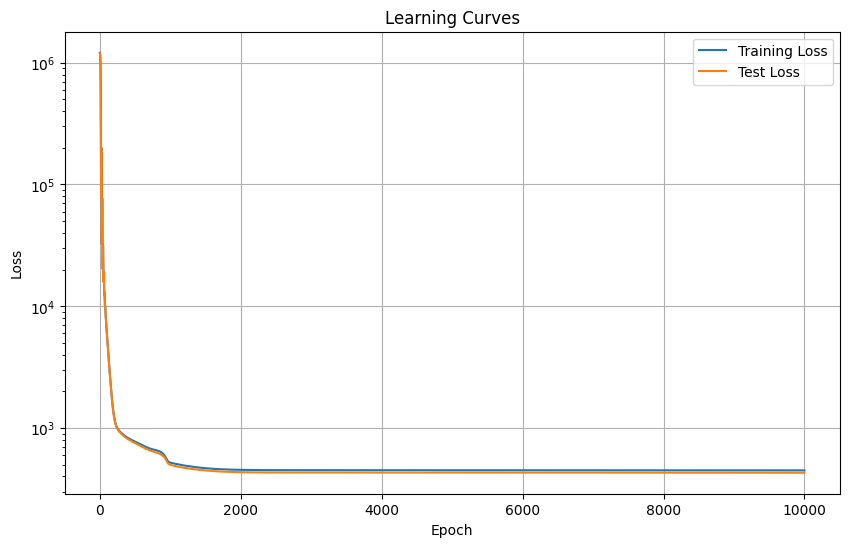

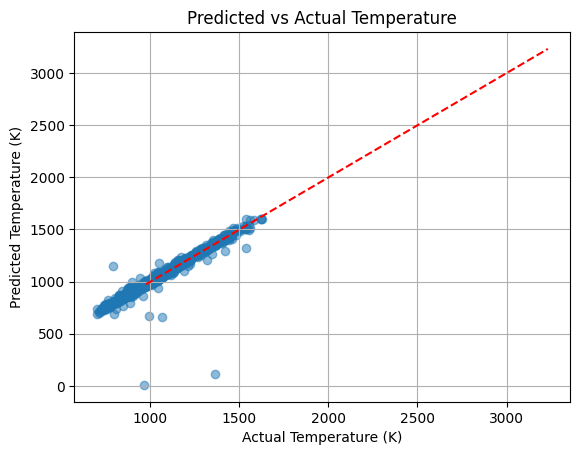

In [10]:
K = 15
L = 2
num_epochs = 10000
lr_init = 0.1
lr_step = num_epochs // 4  # mise à jour du learning rate tous les lr_step epochs
lr_gamma = 0.1  # le learning rate en multiplié par cette valeur tous les lr_step epochs

save_path = f"model_save_K{K}_L{L}_num_epochs{num_epochs}_lrinit{lr_init}_lrstep{lr_step}_lrgamma{lr_gamma}"

model, y_pred_all, y_test_all, train_losses, test_losses = fully_connected_NN(
    df, K, L, num_epochs, lr_init, lr_step, lr_gamma, save_path=save_path
)

In [11]:
params = df.iloc[32][
    ["lhgr", "fuel_radius", "gap_size", "clad_thickness", "coolant_temperature", "time"]
].tolist()
print(
    f"Température prédite : {round(float(predict_temperature(params=params, model_path=save_path)[0]))} K"
)

Température prédite : 1286 K
